<a href="https://colab.research.google.com/github/klaragerlei/GoatsOfAllTime/blob/main/klara_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [3]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Data loading
import numpy as np
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

!git clone https://github.com/klaragerlei/GoatsOfAllTime.git
%cd /content/GoatsOfAllTime
!git pull
import GoatsOfAllTime.data_loader as dl
import GoatsOfAllTime.modify_bin_size as change_bins

data_to_analyze = dl.load_data(alldat, brain_area='MOp', feature='face')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using this device: ')
print(device)



Cloning into 'GoatsOfAllTime'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 276 (delta 135), reused 33 (delta 14), pack-reused 0
Receiving objects: 100% (276/276), 13.81 MiB | 2.16 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/GoatsOfAllTime
Already up to date.
Loading data...
Using this device: 
cuda


In [5]:
data_to_analyze = change_bins.convert_data_to_bigger_bin_size_spikes(data_to_analyze)

Change binning of spike data.
10    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
20    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...
28    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: spikes_bigger_bins, dtype: object


In [6]:
#print(data_to_analyze.spikes.iloc[0])
print(data_to_analyze.spikes.iloc[0].shape)
#print(type(data_to_analyze.spikes.iloc[0]))

#print(data_to_analyze.spikes_bigger_bins_not_flat.iloc[0])
print(data_to_analyze.spikes_bigger_bins_not_flat.iloc[0][0])
print(data_to_analyze.spikes_bigger_bins_not_flat.iloc[0][0].shape)
print(data_to_analyze.spikes_bigger_bins_not_flat.iloc[0].shape)



(447, 342, 250)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(342, 25)
(447, 342, 25)


In [7]:
def convert_data_to_bigger_bin_size_face(data_to_analyze):
  face_data = []
  for session_id, session in data_to_analyze.iterrows():
    face_in_session = session.face
    face_data_flat = face_in_session.reshape(-1)
    face_new_bin_size = change_bins.change_bin_size(face_data_flat, window_size=10)
    face_data.append(face_new_bin_size)
  data_to_analyze['face_bigger_bins'] = face_data
  return data_to_analyze

data_to_analyze = convert_data_to_bigger_bin_size_face(data_to_analyze)

In [8]:
def add_number_of_spikes_per_neuron_to_df(df):
  number_of_spikes = []
  for recording_index, recording in df.iterrows():
    spikes_all = recording.spikes
    spikes_neuron = []
    for neuron in range(spikes_all.shape[0]):
      num_of_spikes = np.sum(spikes_all[neuron])
      spikes_neuron.append(num_of_spikes)
    number_of_spikes.append(spikes_neuron)
  df['number_of_spikes'] = number_of_spikes
  return df      

data_to_analyze = add_number_of_spikes_per_neuron_to_df(data_to_analyze)

In [9]:
# plot spikes across time
def plot_spikes_across_time():
  session_id = 0
  neuron_id = 10
  # spikes_of_neuron = data_to_analyze.spikes[session_id][neuron_id]

  session_to_analyze = data_to_analyze.spikes.iloc[session_id]
  number_of_spikes = data_to_analyze.number_of_spikes.iloc[session_id][neuron_id]
  print('Number of spikes: ' + str(number_of_spikes))
  spikes_of_neuron = session_to_analyze.reshape(session_to_analyze.shape[0], -1)[neuron_id]
  plt.figure()
  plt.plot(spikes_of_neuron)
  plt.show()
  plt.close()

In [10]:
# plot pupil size
def plot_pupil_size():
  print(data_to_analyze.iloc[session_id].pupil.shape)
  pupil_data_to_plot_1 = data_to_analyze.pupil.iloc[session_id][1].T[0]
  pupil_data_to_plot_2 = data_to_analyze.pupil.iloc[session_id][2].T[0]
  print(pupil_data_to_plot.shape)
  plt.figure()
  plt.plot(pupil_data_to_plot_1)
  plt.show()
  plt.close()
  plt.figure()
  plt.plot(pupil_data_to_plot_2)
  plt.show()
  plt.close()

In [11]:
def reshape_pupil_data():
  # Make input features for model
  session_id = 0   # we will analyze this session
  session_to_analyze = data_to_analyze.spikes.iloc[session_id]
  print('number of spikes')
  print(data_to_analyze.number_of_spikes.iloc[session_id])
  print('Number of neurons in this session: ' + str(session_to_analyze.shape[0]))
  # try only one trial
  trial_id = 2
  session_to_analyze_reshaped = session_to_analyze[:,trial_id,:] # first trial 
  pupil_data = data_to_analyze.pupil.iloc[0][0,trial_id]  # first trial 

  print(session_to_analyze_reshaped.shape)
  print(pupil_data.shape)




In [12]:
  def reshape_face_data(data_to_analyze, session_id=0, trial_id=None, spikes_column_name='spikes'):
    # Make input features for model
    session_to_analyze = data_to_analyze[spikes_column_name].iloc[session_id]
    print('number of spikes')
    print(data_to_analyze.number_of_spikes.iloc[session_id])
    #print(session_to_analyze)
    print('Number of neurons in this session: ' + str(session_to_analyze.shape[0]))

    session_to_analyze_reshaped = session_to_analyze[-1] # all trials 
    face_data = data_to_analyze.face.iloc[session_id][0,-1]  # all trials

    if trial_id != None:
      session_to_analyze_reshaped = session_to_analyze[:,trial_id,:] # one trial 
      face_data = data_to_analyze.face.iloc[session_id][0,trial_id]  # one trial 


    #print(session_to_analyze_reshaped.shape)
    #print(face_data.shape)
    return face_data, session_to_analyze_reshaped
behaviour_data, session_to_analyze_reshaped = reshape_face_data(data_to_analyze, trial_id=None)

number of spikes
[4, 1784, 391, 8565, 204, 34, 4777, 301, 64, 5462, 0, 3077, 50, 51, 509, 2135, 141, 64, 5977, 5520, 484, 1822, 9, 79, 0, 287, 556, 41, 100, 14010, 114, 148, 174, 113, 1307, 5292, 147, 1849, 403, 691, 251, 5487, 93, 48, 2263, 59, 76, 100, 10227, 119, 454, 1676, 14, 253, 127, 1110, 1678, 1570, 130, 1812, 200, 117, 126, 7273, 129, 5138, 80, 301, 321, 24, 3637, 21, 5651, 4862, 28, 50, 723, 836, 1071, 50, 5002, 713, 35, 0, 187, 185, 2214, 11, 241, 1630, 2840, 275, 729, 2881, 185, 599, 136, 745, 14723, 217, 11110, 730, 267, 72, 130, 1636, 3669, 140, 1892, 118, 107, 41, 76, 8279, 895, 966, 68, 234, 80, 5509, 287, 6506, 7983, 303, 35, 137, 51, 41, 1265, 143, 180, 309, 1643, 287, 21338, 28892, 16645, 13582, 5876, 15118, 15296, 6715, 4707, 8655, 7542, 6413, 5596, 119, 10387, 5268, 2304, 1554, 1347, 3554, 9785, 140, 1719, 310, 23, 311, 607, 1657, 481, 17437, 1053, 43, 4900, 400, 1345, 6340, 44, 2809, 547, 440, 1845, 75, 1675, 2696, 1114, 321, 2708, 5707, 1953, 2710, 455, 873, 521

Define network

In [20]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=False):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')  # change bidi later
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)
    return z, q

  def predict(self, X_test):
    x0_test, x1_test = convert_for_network(X_test)

    # the network outputs the single-neuron prediction and the latents
    z, y = self(x1_test)

    # our log-likelihood cost
    cost = Poisson_loss(z, x0_test).mean()
    #print('Cost:' + str(cost))
    rpred = z.detach().cpu().numpy()  # predicted output
    return rpred, cost


Split data to training and test (just a single session)

In [21]:
def split_data_to_training_and_test(data_to_analyze, session_id=0, spikes_column_name='spikes', return_indices=False):
  np.random.seed(2021)
  X = data_to_analyze[spikes_column_name].iloc[session_id].transpose(2,1,0)
  # random_indices_test = random.choice(a, size=None, replace=True, p=None)
  # X: time bins by trials by neurons 
  # X: time bins by trials by neurons 
  print('Spike data shape: ' + str(X.shape))
  perm_idcs = np.random.permutation(X.shape[1])
  train_idx = round(0.8 * X.shape[1])
  X_train = X[:,perm_idcs[:train_idx]]
  X_test = X[:,perm_idcs[train_idx:]]
  print('Training data shape: ' + str(X_train.shape))
  print('Test data shape: ' + str(X_test.shape))
  if return_indices:
    return perm_idcs[:train_idx], perm_idcs[train_idx:]
  return X_train, X_test
X_train, X_test = split_data_to_training_and_test(data_to_analyze, session_id=0)
X_train_indices, X_test_indices = split_data_to_training_and_test(data_to_analyze, session_id=0, return_indices=True)

Spike data shape: (250, 342, 447)
Training data shape: (250, 274, 447)
Test data shape: (250, 68, 447)
Spike data shape: (250, 342, 447)
Training data shape: (250, 274, 447)
Test data shape: (250, 68, 447)


In [22]:
# Get movement energy for training and test trials
def get_movement_energy_for_indices(data_to_analyze, indices_to_get, session_id=0):
  session_data = data_to_analyze.face.iloc[session_id]
  selected_trials = session_data[:, indices_to_get, :]
  print(selected_trials.shape)
  return selected_trials

# data_to_analyze.face.iloc[0].shape   # 1, number of trials, number of bins
face_data_train = get_movement_energy_for_indices(data_to_analyze, X_train_indices, session_id=0)
face_data_test  = get_movement_energy_for_indices(data_to_analyze, X_test_indices, session_id=0)

(1, 274, 250)
(1, 68, 250)


In [23]:
# from sklearn.preprocessing import StandardScaler
def product_moment_corr(x,y):
    '''Product-moment correlation for two ndarrays x, y'''
    # x = StandardScaler().fit_transform(x)
    # y = StandardScaler().fit_transform(y)
    n = x.shape[0]
    r = (1/(n-1))*(x.T @ y).sum(axis=0)
    return np.mean(r)

#from scipy.stats import pearsonr
def corr3d(a, b):
  correlations = np.zeros(a.shape[2])
  for i in np.arange(a.shape[2]):
      correlations[i] = product_moment_corr(a[:,:,i],b[:,:,i])
  return np.mean(correlations)

Prepare input for autoencoder

In [24]:
def convert_for_network(session_data):
  x0 = torch.from_numpy(session_data).to(device).float()
  x1 = torch.from_numpy(session_data).to(device).float()
  return x0, x1
x0, x1 = convert_for_network(X_train)  # x0 and x1 are the same

Initialize network

In [25]:
def initialize_network():
  NN1 = x1.shape[-1]
  NN2 = x0.shape[-1]

  # let's use 10 latent components
  ncomp = 10

  # we initialize the neural network
  net = Net(ncomp, NN1, NN2, bidi = True).to(device)

  # special thing:  we initialize the biases of the last layer in the neural network
  # we set them as the mean firing rates of the neurons.
  # this should make the initial predictions close to the mean, because the latents don't contribute much
  net.fc.bias.data[:] = x1.mean((0,1))  # !!!!!!!!!!!

  # we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
  optimizer = torch.optim.Adam(net.parameters(), lr=.005)
  return net, optimizer, ncomp
net, optimizer, ncomp = initialize_network()

Train network on split data (half of neurons in x0 and half in x1)

In [26]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

iterations = []
correlations = []
costs = []
costs_test = []
latent_variables_all = []


def train_network(net, x0, x1):
  niter = 1000
  for k in range(niter):
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1)

    # our log-likelihood cost
    cost = Poisson_loss(z, x0).mean()

    # train the network as usual
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

    if k % 100 == 0:
      rpred_train = z.detach().cpu().numpy()  # predicted output
      rpred_test, cost_test = net.predict(X_test)
      correlation = corr3d(rpred_train, rpred_test)
      iterations.append(k)
      correlations.append(correlation)
      costs.append(cost.item())
      costs_test.append(cost_test.item())
      latent_variables_all.append(y.detach().cpu().numpy())
      print(f'iteration {k}, cost {cost.item():.4f}, cost_test {cost_test.item():.4f}, correlation {correlation:.4f}')
    
    rpred = z.detach().cpu().numpy()  # predicted output
    latent_variables = y.detach().cpu().numpy()
    #print(rpred)
  return rpred, latent_variables
rpred, latent_variables = train_network(net, x0, x1)


iteration 0, cost 0.2106, cost_test 0.2044, correlation 5.6166
iteration 100, cost 0.1004, cost_test 0.1035, correlation 1.6133
iteration 200, cost 0.0969, cost_test 0.1002, correlation 1.6969
iteration 300, cost 0.0951, cost_test 0.0984, correlation 1.7176
iteration 400, cost 0.0942, cost_test 0.0975, correlation 1.7310
iteration 500, cost 0.0937, cost_test 0.0971, correlation 1.7417
iteration 600, cost 0.0934, cost_test 0.0967, correlation 1.7480
iteration 700, cost 0.0931, cost_test 0.0965, correlation 1.7525
iteration 800, cost 0.0929, cost_test 0.0963, correlation 1.7584
iteration 900, cost 0.0928, cost_test 0.0962, correlation 1.7629


In [27]:
def save_latent_variables(latent_variables, latent_variables_path='/content/latent_variables.npy'):
  latent_variables_path = '/content/latent_variables_all_no_bidi.npy'
  if not os.path.exists(latent_variables_path):
    np.save(latent_variables_path, latent_variables)
    print('Saving latent variables here: ' + latent_variables_path)

save_latent_variables(latent_variables_all)

Saving latent variables here: /content/latent_variables_all_no_bidi.npy


In [ ]:
def load_latent_variables(latent_variables_path='/content/latent_variables.npy'):
  latent_variables = False
  if os.path.exists(latent_variables_path):
    latent_variables = np.load(latent_variables_path, latent_variables)
    print('Loading latent variables from here: ' + latent_variables_path)
  else:
    print('There are no latent variables to load here: ' + latent_variables_path)
  return latent_variables
# latent_vars = load_latent_variables()
# latent_vars.shape

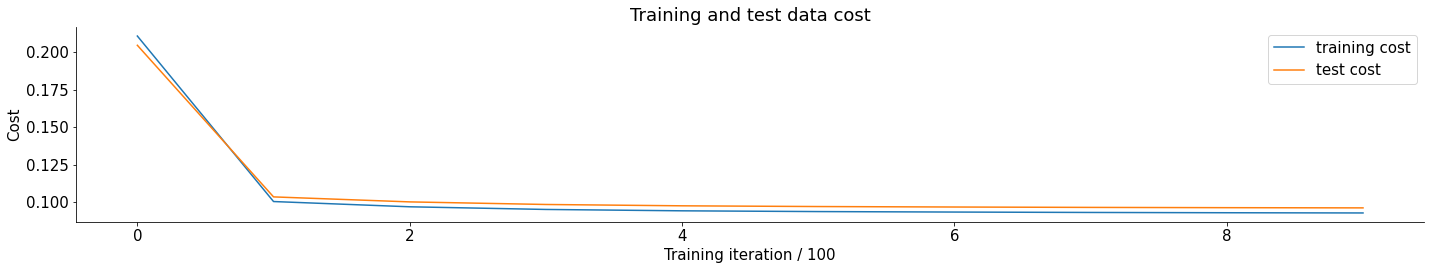

In [28]:
def plot_training_vs_test_cost(training_cost, test_cost):
  plt.figure()
  plt.plot(training_cost, label='training cost')
  plt.plot(test_cost, label='test cost')
  plt.title('Training and test data cost')
  plt.ylabel('Cost')
  plt.xlabel('Training iteration / 100')
  plt.legend()
  plt.show()
  plt.close()

plot_training_vs_test_cost(costs, costs_test)

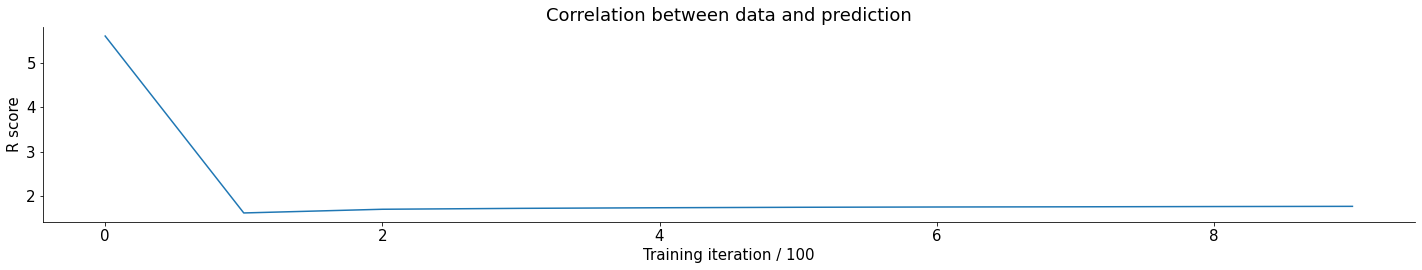

In [29]:
def plot_correlation_between_data_and_prediction(correlations):
  plt.figure()
  plt.plot(correlations)
  plt.xlabel('Training iteration / 100')
  plt.title('Correlation between data and prediction')
  plt.ylabel('R score')
  plt.show()
  plt.close()
plot_correlation_between_data_and_prediction(correlations)

Plot prediction vs data for the training data

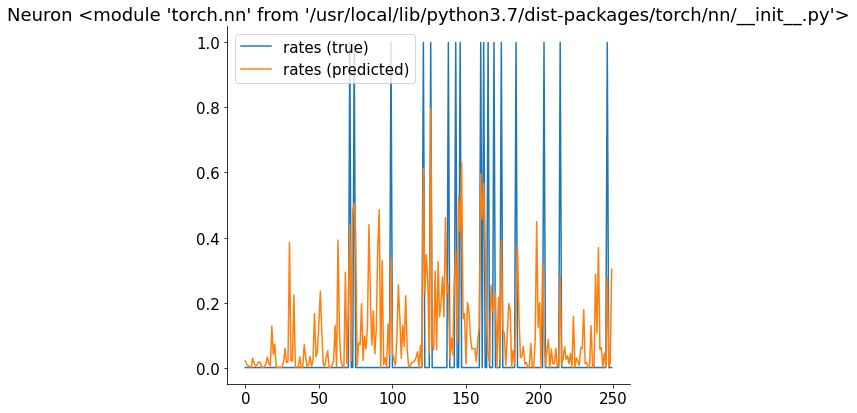

In [30]:
def plot_prediction_vs_data(rpred, x0, neuron_id=0, trial_id=29):
  x0_rates = x0.detach().cpu().numpy()
  plt.figure(figsize=(10, 6))
  plt.plot(x0_rates[:,trial_id, neuron_id])
  plt.plot(rpred[:,trial_id, neuron_id])
  # plt.plot(-.5 + x[:, nn, 0]/4) # these are spikes we don't have that

  plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
  plt.title(f'Neuron {nn}')
  plt.show()
plot_prediction_vs_data(rpred, x0, neuron_id=29, trial_id=1)

(250, 274, 447)


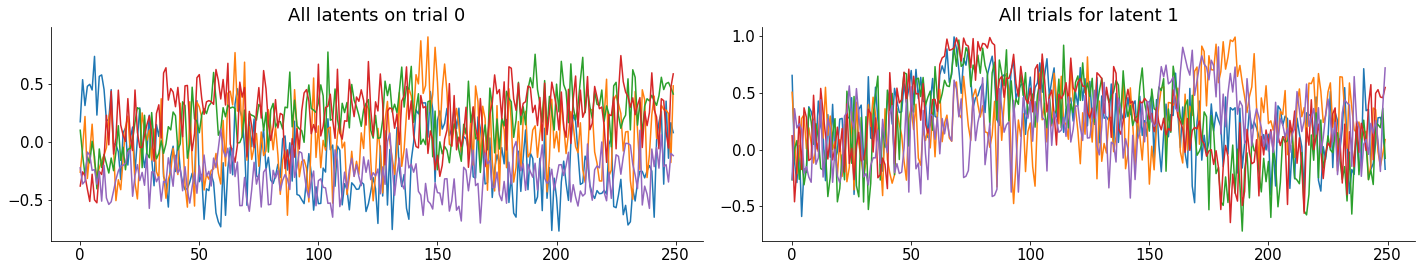

In [31]:
def view_latents(latents,trialToView=0,latentToView=1,latentRangeForTrials = (0,5),trialRangeForLatents = (5,10)):
  print(rpred.shape)
  latentRange = range(latentRangeForTrials[0],latentRangeForTrials[1],1)
  trialRange = range(trialRangeForLatents[0],trialRangeForLatents[1],1)
  plt.figure(figsize=(20, 4))
  plt.subplot(121)
  plt.plot(latents[:, trialToView, list(latentRange)]);
  plt.title('All latents on trial ' + str(trialToView))

  plt.subplot(122)
  plt.plot(latents[:,list(trialRange), latentToView]);
  plt.title('All trials for latent ' + str(latentToView))
  plt.show()
view_latents(latent_variables)

In [32]:
# latent_variables_last = latent_variables[:,:,-1]
print(latent_variables.shape)   # number of bins, number of training trials
#plt.figure()
#plt.plot(latent_variables_last[:, 22])
#plt.show()
#plt.close()
# todo flatten both along trials axis
# print(latent_variables_last[0].shape)
# latent_variables_reshaped = latent_variables_last.reshape(latent_variables_last.shape[0], -1)
latent_variables_reshaped = latent_variables.reshape(latent_variables.shape[2], -1)
print(latent_variables_reshaped.shape)
# face_data_reshaped = face_data_train.T[:,:,0]
face_data_reshaped = face_data_train.T[:,:,0].reshape(-1)
print(face_data_reshaped.shape)

(250, 274, 10)
(10, 68500)
(68500,)


In [ ]:
# do t-sne on last set of latent variables
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=15, random_state=2020)
embed = tsne_model.fit_transform(latent_variables_reshaped.T)  # Embedding of the training data in low-dimensional space.

In [ ]:
embed.shape

(68500, 2)

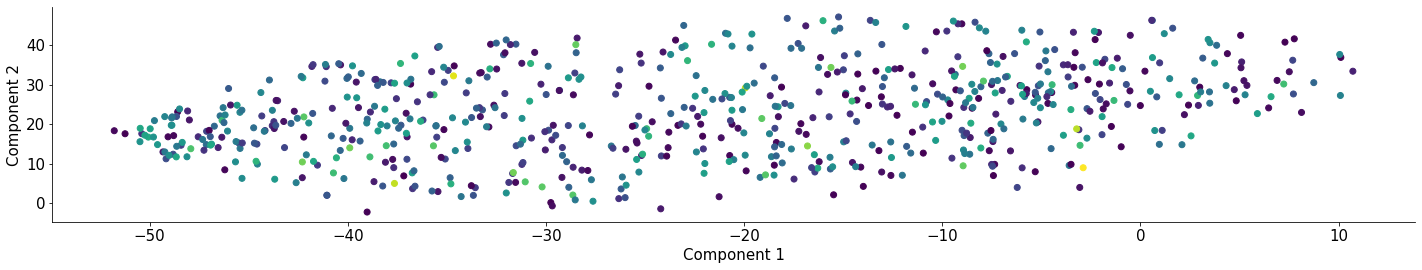

In [ ]:
def plot_tsne_results(embed):
  plt.figure()
  plt.scatter(embed[::100, 0], embed[::100, 1], c=face_data_reshaped[::100])
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.show()
  plt.close()
plot_tsne_results(embed)

Check how well the model is doing on the test data

In [1]:
def run_model_on_test_data(X_test, net):
  x0_test, x1_test = convert_for_network(X_test)  # 
  
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1_test)

  # our log-likelihood cost
  cost = Poisson_loss(z, x0_test).mean()
  print('----------------------------')
  print('This is for the test data')
  print('Cost:' + str(cost))
  rpred = z.detach().cpu().numpy()  # predicted output
  return rpred, cost

rpred, cost = run_model_on_test_data(X_test, net)

NameError: ignored

Initialize another network (Net2)

In [ ]:
def initialize_network():
  NN1 = x1.shape[-1]
  NN2 = x0.shape[-1]

  # let's use 10 latent components
  ncomp = 10

  # we initialize the neural network
  net = Net2(ncomp, NN1, NN2, bidi = True).to(device)

  # special thing:  we initialize the biases of the last layer in the neural network
  # we set them as the mean firing rates of the neurons.
  # this should make the initial predictions close to the mean, because the latents don't contribute much
  net.fc.bias.data[:] = x1.mean((0,1))  # !!!!!!!!!!!

  # we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
  optimizer = torch.optim.Adam(net.parameters(), lr=.005)
  return net, optimizer
net2, optimizer, ncomp = initialize_network()

Train net2

In [ ]:
rpred, latent_variables = train_network(net2, x0, x1)

iteration 0, cost 1.4800
iteration 100, cost 0.2418
iteration 200, cost 0.2327
iteration 300, cost nan
iteration 400, cost nan
iteration 500, cost nan
iteration 600, cost nan
iteration 700, cost nan
iteration 800, cost nan
iteration 900, cost nan


Run net2 on test data

In [ ]:
rpred, cost = run_model_on_test_data(X_test, net2)

Cost:tensor(0.1580, device='cuda:0', grad_fn=<MeanBackward0>)


Do this again with bigger bins (100ms)

number of spikes
[4, 1784, 391, 8565, 204, 34, 4777, 301, 64, 5462, 0, 3077, 50, 51, 509, 2135, 141, 64, 5977, 5520, 484, 1822, 9, 79, 0, 287, 556, 41, 100, 14010, 114, 148, 174, 113, 1307, 5292, 147, 1849, 403, 691, 251, 5487, 93, 48, 2263, 59, 76, 100, 10227, 119, 454, 1676, 14, 253, 127, 1110, 1678, 1570, 130, 1812, 200, 117, 126, 7273, 129, 5138, 80, 301, 321, 24, 3637, 21, 5651, 4862, 28, 50, 723, 836, 1071, 50, 5002, 713, 35, 0, 187, 185, 2214, 11, 241, 1630, 2840, 275, 729, 2881, 185, 599, 136, 745, 14723, 217, 11110, 730, 267, 72, 130, 1636, 3669, 140, 1892, 118, 107, 41, 76, 8279, 895, 966, 68, 234, 80, 5509, 287, 6506, 7983, 303, 35, 137, 51, 41, 1265, 143, 180, 309, 1643, 287, 21338, 28892, 16645, 13582, 5876, 15118, 15296, 6715, 4707, 8655, 7542, 6413, 5596, 119, 10387, 5268, 2304, 1554, 1347, 3554, 9785, 140, 1719, 310, 23, 311, 607, 1657, 481, 17437, 1053, 43, 4900, 400, 1345, 6340, 44, 2809, 547, 440, 1845, 75, 1675, 2696, 1114, 321, 2708, 5707, 1953, 2710, 455, 873, 521

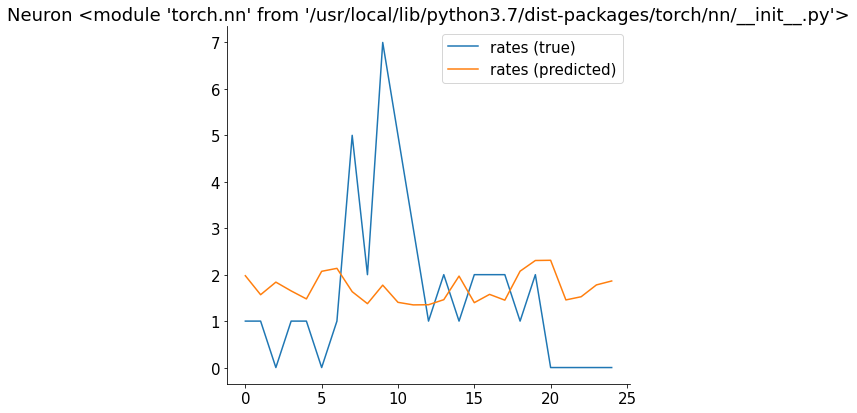

In [ ]:
def run_model_on_data_with_bigger_bins(data_to_analyze):
  behaviour_data, session_to_analyze_reshaped = reshape_face_data(data_to_analyze, trial_id=None, spikes_column_name='spikes_bigger_bins_not_flat')
  X_train, X_test = split_data_to_training_and_test(data_to_analyze, session_id=0, spikes_column_name='spikes_bigger_bins_not_flat')
  x0, x1 = convert_for_network(X_train)
  net, optimizer, ncomp = initialize_network()
  rpred, latent_variables = train_network(net, x0, x1)
  rpred, cost = run_model_on_test_data(X_test, net)
  return rpred, x0
rpred_rebinned, x0_rebinned = run_model_on_data_with_bigger_bins(data_to_analyze)
plot_prediction_vs_data(rpred_rebinned, x0_rebinned, neuron_id=29, trial_id=1)

In [ ]:
Split the data (half of neurons in one group and the other half in the other) and rerun everything

In [ ]:
def split_across_neurons(session_data):
  # session_data = data_to_analyze.spikes.iloc[session_id]
  # todo x0 should be the spikes and x1 the behaviour
  neuron_split_idx = session_data.shape[2] // 2
  x0 = torch.from_numpy(session_data[:,:,:neuron_split_idx]).to(device).float()
  x1 = torch.from_numpy(session_data[:,:,neuron_split_idx:neuron_split_idx*2]).to(device).float()
  return x0, x1
x0, x1 = split_across_neurons(X_train)

In [ ]:
def run_model_on_test_data_split(X_test, net):
  x0_test, x1_test = split_across_neurons(X_test)  # 
  
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1_test)

  # our log-likelihood cost
  cost = Poisson_loss(z, x0_test).mean()
  print('----------------------------')
  print('This is for the test data')
  print('Cost:' + str(cost))
  rpred = z.detach().cpu().numpy()  # predicted output
  return rpred, cost

rpred, cost = run_model_on_test_data_split(X_test, net)

RuntimeError: ignored

In [ ]:
def run_model_on_data_split(data_to_analyze):
  behaviour_data, session_to_analyze_reshaped = reshape_face_data(data_to_analyze, trial_id=None, spikes_column_name='spikes')
  X_train, X_test = split_data_to_training_and_test(data_to_analyze, session_id=0, spikes_column_name='spikes')
  x0, x1 = split_across_neurons(X_train)
  net, optimizer, ncomp = initialize_network()
  rpred, latent_variables = train_network(net, x0, x1)
  rpred, cost = run_model_on_test_data(X_test, net)
  return rpred, x0
rpred_rebinned, x0_rebinned = run_model_on_data_with_bigger_bins(data_to_analyze)
plot_prediction_vs_data(rpred_rebinned, x0_rebinned, neuron_id=29, trial_id=1)

number of spikes
[4, 1784, 391, 8565, 204, 34, 4777, 301, 64, 5462, 0, 3077, 50, 51, 509, 2135, 141, 64, 5977, 5520, 484, 1822, 9, 79, 0, 287, 556, 41, 100, 14010, 114, 148, 174, 113, 1307, 5292, 147, 1849, 403, 691, 251, 5487, 93, 48, 2263, 59, 76, 100, 10227, 119, 454, 1676, 14, 253, 127, 1110, 1678, 1570, 130, 1812, 200, 117, 126, 7273, 129, 5138, 80, 301, 321, 24, 3637, 21, 5651, 4862, 28, 50, 723, 836, 1071, 50, 5002, 713, 35, 0, 187, 185, 2214, 11, 241, 1630, 2840, 275, 729, 2881, 185, 599, 136, 745, 14723, 217, 11110, 730, 267, 72, 130, 1636, 3669, 140, 1892, 118, 107, 41, 76, 8279, 895, 966, 68, 234, 80, 5509, 287, 6506, 7983, 303, 35, 137, 51, 41, 1265, 143, 180, 309, 1643, 287, 21338, 28892, 16645, 13582, 5876, 15118, 15296, 6715, 4707, 8655, 7542, 6413, 5596, 119, 10387, 5268, 2304, 1554, 1347, 3554, 9785, 140, 1719, 310, 23, 311, 607, 1657, 481, 17437, 1053, 43, 4900, 400, 1345, 6340, 44, 2809, 547, 440, 1845, 75, 1675, 2696, 1114, 321, 2708, 5707, 1953, 2710, 455, 873, 521

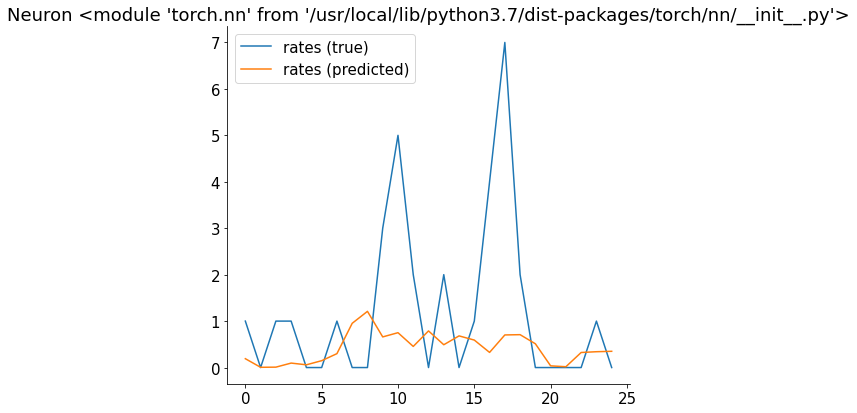

In [ ]:
def run_model_on_data_with_bigger_bins_split(data_to_analyze):
  behaviour_data, session_to_analyze_reshaped = reshape_face_data(data_to_analyze, trial_id=None, spikes_column_name='spikes_bigger_bins_not_flat')
  X_train, X_test = split_data_to_training_and_test(data_to_analyze, session_id=0, spikes_column_name='spikes_bigger_bins_not_flat')
  x0, x1 = split_across_neurons(X_train)
  net, optimizer, ncomp = initialize_network()
  rpred, latent_variables = train_network(net, x0, x1)
  rpred, cost = run_model_on_test_data(X_test, net)
  return rpred, x0
rpred_rebinned, x0_rebinned = run_model_on_data_with_bigger_bins(data_to_analyze)
plot_prediction_vs_data(rpred_rebinned, x0_rebinned, neuron_id=29, trial_id=1)

In [ ]:
rpred_split, x0_split = run_model_on_data_split(data_to_analyze)
plot_prediction_vs_data(rpred_split, x0_split, neuron_id=29, trial_id=1)

In [ ]:
rpred_rebinned_split, x0_rebinned_split = run_model_on_data_with_bigger_bins_split(data_to_analyze)
plot_prediction_vs_data(rpred_rebinned_split, x0_rebinned_split, neuron_id=29, trial_id=1)